In [2]:
# Run this only if you are using Google Colab
from google.colab import drive
import os

drive.mount('/content/drive')

# change path here as per your directory structure
# os.chdir('/content/drive/MyDrive/Documents/Sem6-drive/RL/Tutorial/3Tut/QLearning_SARSA.ipynb')

Mounted at /content/drive


In [ ]:
# Install relevant libraries
!pip install numpy matplotlib tqdm scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 3.8 MB/s eta 0:00:0000:0100:01
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline

# Problem Statement

In this section we will implement tabular SARSA and Q-learning algorithms for a grid world navigation task.

## Environment details
The agent can move from one grid coordinate to one of its adjacent grids using one of the four actions: UP, DOWN, LEFT and RIGHT. The goal is to go from a randomly assigned starting position to goal position.

Actions that can result in taking the agent off the grid will not yield any effect.
Lets look at the environment.


In [ ]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

Let us construct a grid in a text file.

In [ ]:
!cat grid_world2.txt

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


This is a $17\times 23$ grid. The reward when an agent goes to a cell is negative of the value in that position in the text file (except if it is the goal cell). We will define the goal reward as 100. We will also fix the maximum episode length to 10000.

Now let's make it more difficult. We add stochasticity to the environment: with probability 0.2 agent takes a random action (which can be other than the chosen action).
There is also a westerly wind blowing (to the right). Hence, after every time-step, with probability 0.5 the agent also moves an extra step to the right.

Now let's plot the grid world.

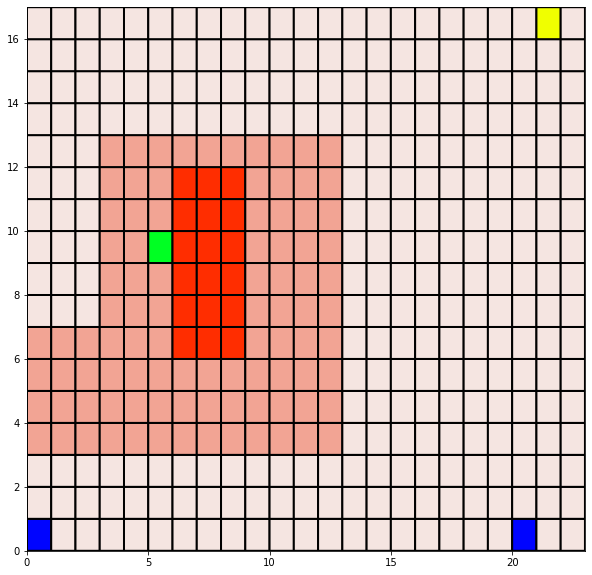

In [ ]:
world = 'grid_world2.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

### Legend
- <span style="color:#0004FF">*Blue*</span> is the **start state**.
- <span style="color:#00FF23">*Green*</span> is the **goal state**.
- <span style="color:#F0FF00">*Yellow*</span> is current **state of the agent**.
- <span style="color:#FF2D00">*Redness*</span> denotes the extent of **negative reward**.

### Q values
We can use a 3D array to represent Q values. The first two indices are X, Y coordinates and last index is the action.

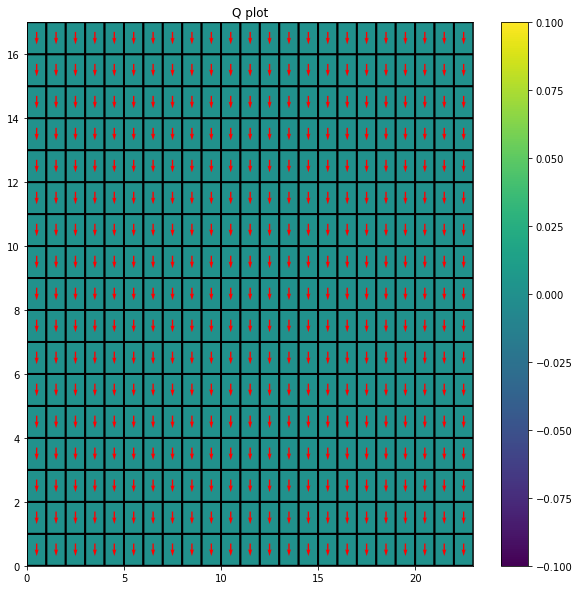

(17, 23, 4)

In [ ]:
from grid_world import plot_Q

Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

plot_Q(Q)

Q.shape

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [ ]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if not Q[state[0], state[1]].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
    else:
        return np.argmax(Q[state[0], state[1]])

# Softmax
def choose_action_softmax(Q, state, rg=rg):
    return rg.choice(Q.shape[-1], p = softmax(Q[state[0], state[1]]))

## SARSA
Now we implement the SARSA algorithm.

Recall the update rule for SARSA:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have som hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

In [ ]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

Let's implement SARSA

In [ ]:
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)
            
            # update equation
            Q[state[0], state[1], action] += alpha*(reward + gamma*Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

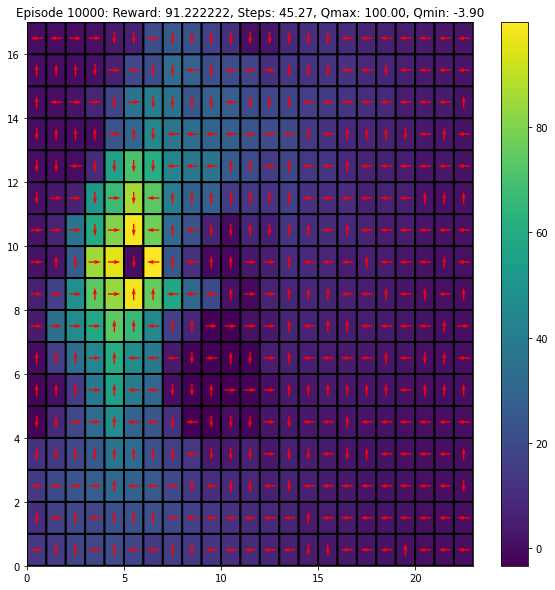

100%|██████████| 10000/10000 [01:37<00:00, 102.43it/s]


In [ ]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

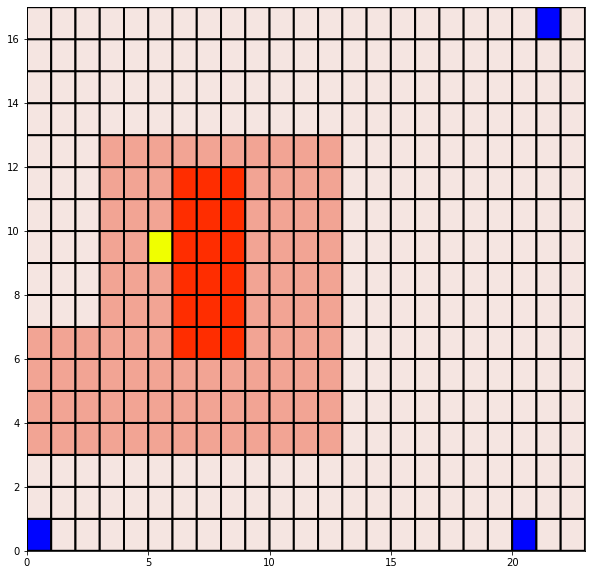

Steps: 25, Total Reward: 94


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy
We use two metrics to analyze the policies:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

In [ ]:
Q_avgs, reward_avgs, steps_avgs = [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    Q, rewards, steps = sarsa(env, Q)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

Experiment: 1


100%|██████████| 10000/10000 [00:42<00:00, 234.40it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:53<00:00, 187.23it/s]


Experiment: 3


100%|██████████| 10000/10000 [01:07<00:00, 147.33it/s]


Experiment: 4


100%|██████████| 10000/10000 [01:45<00:00, 94.98it/s]


Experiment: 5


100%|██████████| 10000/10000 [01:12<00:00, 137.73it/s]


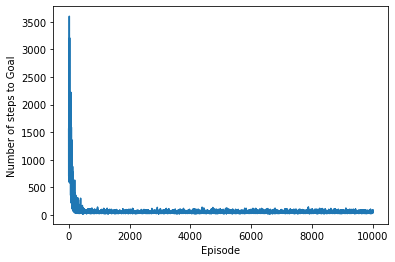

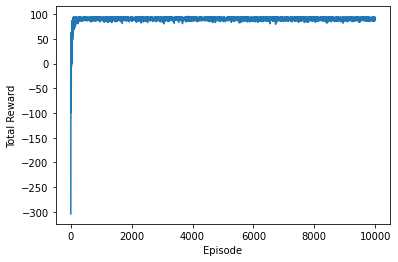

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

## Q-Learning
Now, implement the Q-Learning algorithm as an exercise.

Recall the update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

Visualize and compare results with SARSA.

In [ ]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

Implementing Q Learning

In [ ]:
print_freq = 100

def q_learning(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        #action = choose_action(Q, state)
        done = False
        while not done:
            action = choose_action(Q, state)
            state_next, reward, done = env.step(action)
            #action_next = choose_action(Q, state_next)
            action_next = np.argmax(Q[state_next[0], state_next[1]])
            # update equation
            Q[state[0], state[1], action] += alpha*(reward + gamma*Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

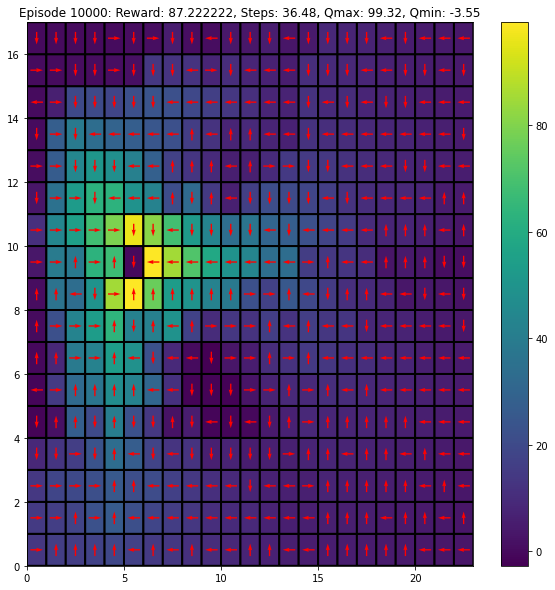

100%|██████████| 10000/10000 [02:04<00:00, 80.46it/s]


In [ ]:
Q, rewards, steps = q_learning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

### Visualizing Q learning

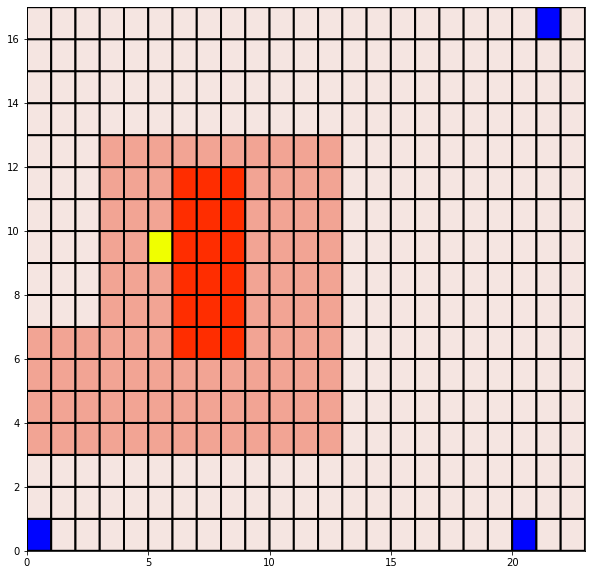

Steps: 28, Total Reward: 89


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy

In [ ]:
Q_avgs, reward_avgs, steps_avgs = [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    Q, rewards, steps = q_learning(env, Q)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

Experiment: 1


100%|██████████| 10000/10000 [01:17<00:00, 129.00it/s]


Experiment: 2


100%|██████████| 10000/10000 [01:35<00:00, 105.21it/s]


Experiment: 3


100%|██████████| 10000/10000 [01:51<00:00, 90.02it/s]


Experiment: 4


100%|██████████| 10000/10000 [01:25<00:00, 116.54it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:54<00:00, 185.16it/s]


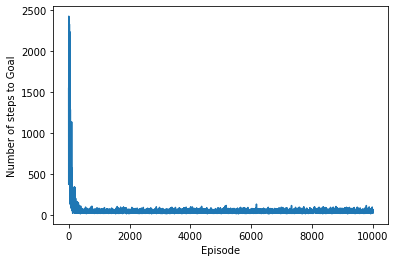

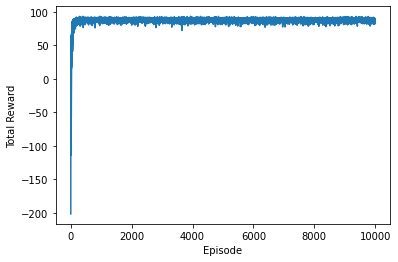

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

### q_learning vs SARSA

In [ ]:
# sarsa
Q_avgs_sarsa, reward_avgs_sarsa, steps_avgs_sarsa = [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    Q, rewards, steps = sarsa(env, Q)
    Q_avgs_sarsa.append(Q.copy())
    reward_avgs_sarsa.append(rewards)
    steps_avgs_sarsa.append(steps)
    

# Q learning

Q_avgs_q, reward_avgs_q, steps_avgs_q = [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    Q, rewards, steps = q_learning(env, Q)
    Q_avgs_q.append(Q.copy())
    reward_avgs_q.append(rewards)
    steps_avgs_q.append(steps)

Experiment: 1


100%|██████████| 10000/10000 [01:05<00:00, 152.92it/s]


Experiment: 2


100%|██████████| 10000/10000 [01:17<00:00, 128.83it/s]


Experiment: 3


100%|██████████| 10000/10000 [01:02<00:00, 160.93it/s]


Experiment: 4


100%|██████████| 10000/10000 [01:01<00:00, 161.81it/s]


Experiment: 5


100%|██████████| 10000/10000 [01:01<00:00, 161.37it/s]


Experiment: 1


100%|██████████| 10000/10000 [01:12<00:00, 138.04it/s]


Experiment: 2


100%|██████████| 10000/10000 [02:08<00:00, 77.97it/s]


Experiment: 3


100%|██████████| 10000/10000 [01:45<00:00, 95.18it/s]


Experiment: 4


100%|██████████| 10000/10000 [01:36<00:00, 103.47it/s]


Experiment: 5


100%|██████████| 10000/10000 [01:02<00:00, 160.51it/s]


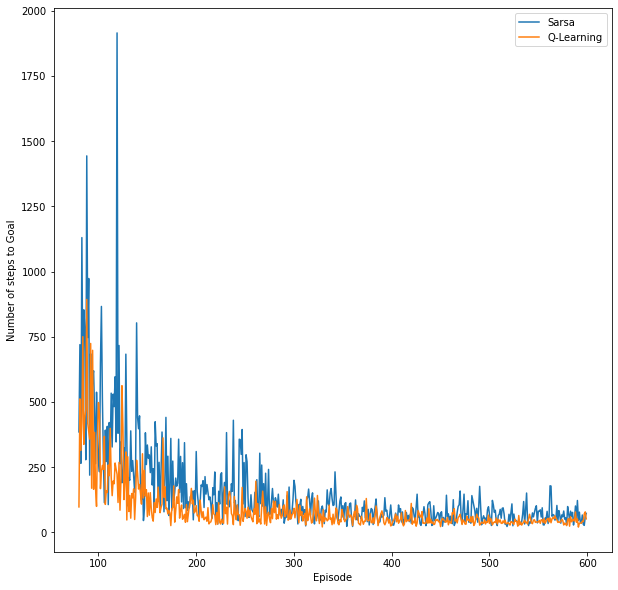

In [ ]:
# initital episodes
start_epi = 80
end_epi = 600

plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')

plt.plot(np.arange(episodes)[start_epi:end_epi] ,np.average(steps_avgs_sarsa, 0)[start_epi:end_epi] , label = "Sarsa")
plt.plot(np.arange(episodes)[start_epi:end_epi],np.average(steps_avgs_q, 0)[start_epi:end_epi] , label = "Q-Learning")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

From the above figure it is clear that Q-learning converges faster than SARSA. Observe that the orange curve is below the blue curve in the figure for the most of the time.

Orange curve ( Q learning ) stabilized faster than the blue curve( SARSA )

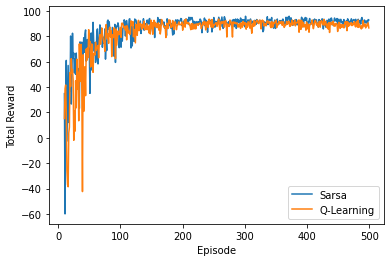

In [ ]:
# initital episodes
start_epi = 10
end_epi = 500

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes)[start_epi:end_epi],np.average(reward_avgs_sarsa, 0)[start_epi:end_epi] , label = "Sarsa")
plt.plot(np.arange(episodes)[start_epi:end_epi],np.average(reward_avgs_q, 0)[start_epi:end_epi] , label = "Q-Learning")
plt.legend()

# fig = plt.gcf()
# fig.set_size_inches(10, 10)

plt.show()

Not a lot of difference can be obseved in the figure.

But intrestingly the blue curve is a little higher than the orange curve.

## Code for converting to pdf file ( IGNORE )

In [1]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [3]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Documents/Sem6-drive/RL/Tutorial/3Tut/QLearning_SARSA.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Documents/Sem6-drive/RL/Tutorial/3Tut/QLearning_SARSA.ipynb to pdf
[NbConvertApp] Support files will be in QLearning_SARSA_files/
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Making directory ./QLearning_SARSA_files
[NbConvertApp] Writing 93311 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./no